In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
#set the path to data
PATH = "data/dogscats/"
#this variable is used for resizing all images to its value which has faster training.
sz=224

In [6]:
torch.cuda.is_available()

True

In [7]:
#check if cudnn is properly installed or not
# it is a accelerated deep learning library which significantly improves training time 
torch.backends.cudnn.enabled

True

In [8]:
#let us have a look at dtaa
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'test1']

In [9]:
#use python 3 file format string
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [10]:
#let us have a look at one of the images
files = os.listdir(f'{PATH}valid/cats')[:5]

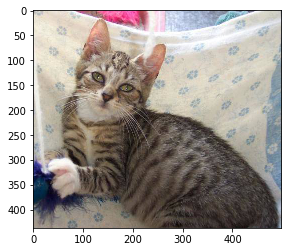

In [11]:
#let us have a look at one of the file
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [12]:
#check the shape of image
#it is a rank 3 tensor. It has r g b value for each pixel
img.shape

(437, 499, 3)

## Let us build a model. A Resnet Model

### Here we are using a pre trained model from imagenet competetion. It is called resnet43.

In [13]:
#setting the architecture of cnn
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 24751869.64it/s]


100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.042457   0.025286   0.9925    
    1      0.039384   0.030789   0.9905                       



[array([0.03079]), 0.9905]

### Analyzing Results

In [14]:
#to see actual labels of validation data
# o is cat and 1 is dog
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
data.classes

['cats', 'dogs']

In [16]:
#pytorch gives predictions in log scale!
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
log_preds[:10,:]

array([[ -0.00005,  -9.94646],
       [ -0.00117,  -6.7541 ],
       [ -0.00282,  -5.87316],
       [ -0.00193,  -6.25048],
       [ -0.00011,  -9.15051],
       [ -0.0002 ,  -8.51126],
       [ -0.00029,  -8.14136],
       [ -0.00006,  -9.68265],
       [ -0.00404,  -5.51267],
       [ -0.00004, -10.07326]], dtype=float32)

In [18]:
#pytorch api actually gives natural logarithm to the base exponential of probablities.
#to convert it into binary classes i.e. o or 1 we will make use of numpy argmax api which works across rows and gives out the index of maximum value. i.e. 0 or 1!
preds = np.argmax(log_preds,axis=1)

In [19]:
#to get probabilities from log probabilities we will take exponential of natural log to the base  e which will give us back the probability.
probs = np.exp(log_preds[:,1]) #for dog

In [20]:
#fast ai has following attributes for datasets
data.val_ds

## Analyzing Results


-> A few correct labels at random
-> A few incorrect labels at random
-> The most correct labels of each class (i.e. those with highest probability that are correct)
-> The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
-> The most uncertain labels (i.e. those with probability closest to 0.5)

In [21]:
def rand_by_mask(mask):
    #the goal of np.where is to give x or y based on condition
    # if only condition is given then it only 
    #returns the indices  where condition is true
    arg1 = np.where(mask)[0]
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


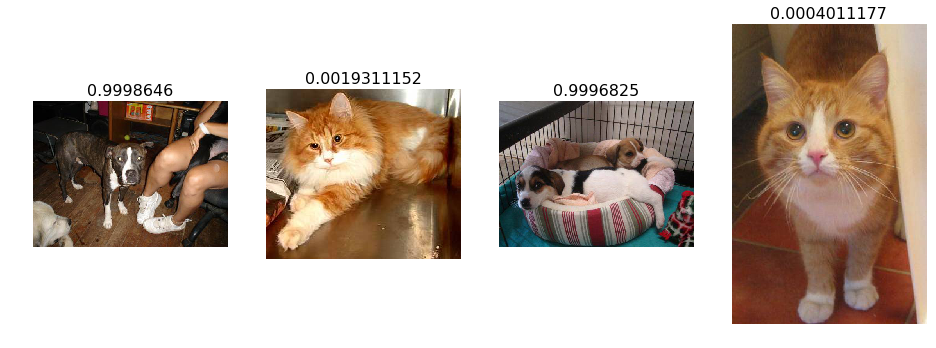

In [25]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


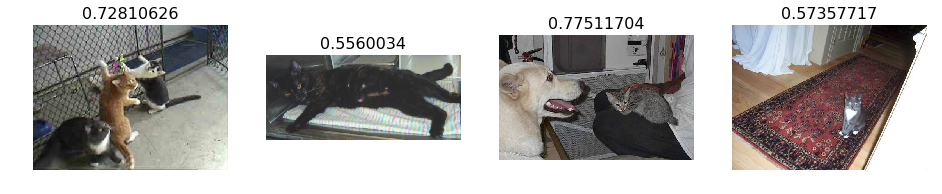

In [26]:
#let us get incorrect labels 
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

### looking for mostly correct labels

In [27]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    result = idxs[np.argsort(mult * probs[idxs])[:4]]
    prob_result = mult * probs[idxs]
    return result
#here we multiple 1 for cats and -1 for dogs to their repective probabilites to make sure sorting occurs properly.Because
# the intent is to show the pictures in decreasing order of their correctness.
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


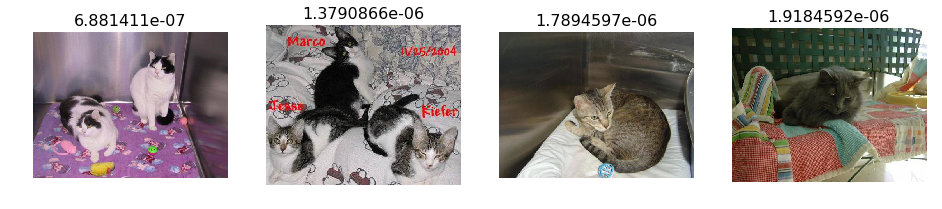

In [28]:
    plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct DOGS


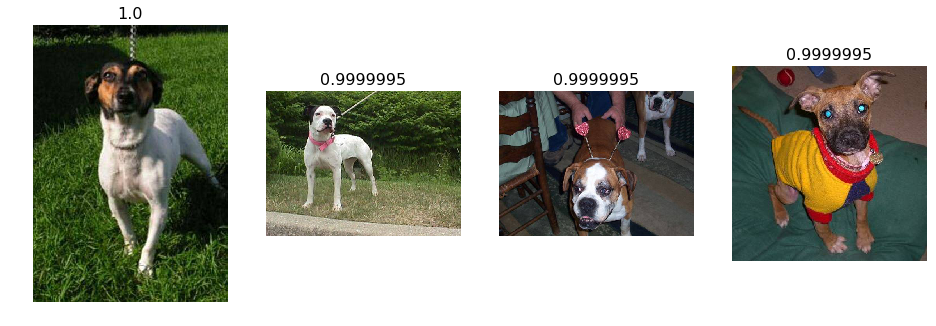

In [29]:
plot_val_with_title(most_by_correct(1, True), "Most correct DOGS")

### NOW WE WILL BE LOOKING AT MOST UNCERTAIN RESULTS

Most uncertain predictions


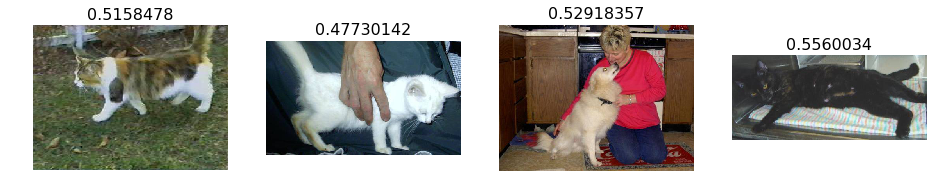

In [30]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## LEARNING RATE

### As we all know Learning rate is the most important hyperparameter and also affects model's performance significantly. 
### We are going to use something called cyclic learning rate i.e. implemented based on this research paper https://arxiv.org/abs/1506.01186. 

### The technique suggests that if we start with some random point and then take tiny steps. At each step we double the size of step i.e. learning rate. Plot a graph of learning rate vs iterations and a graph of learning rate vs loss. In the graph of learning rate vs loss we will select a point before the point after which the loss got a bump up instead of going lower.


In [31]:
#let us first create a new model in which we will just
#compute learning rate by updating weights in the last layer
learn = ConvLearner.pretrained(arch,data,precompute=True)


In [32]:
lr = learn.lr_find()

 76%|███████▌  | 274/360 [00:04<00:01, 55.47it/s, loss=0.479]


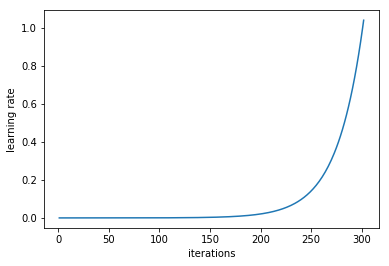

In [33]:
# As we see in the previous cell the training stops as soon as the technique finds out the next point leads to increase in loss.
#let us plot now learning rate vs iterations 
learn.sched.plot_lr()
            

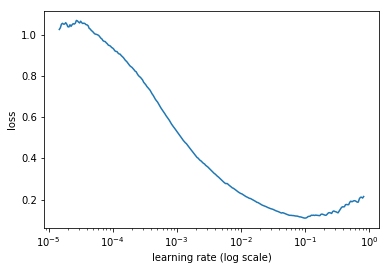

In [34]:
#earning rate vs loss
learn.sched.plot()

## IMPROVING OUR MODEL

### DATA AUGMENTATION

Why we are using Data Augmentation!
Let us understand with the help of example that we have here. Suppose we have collected photos of cats in mostly one-two angles with single camera. Now if we want out model to recognize cats photos' which are shot from different angle with different contrast then we use this data augmentation technique. Instead of collecting all sorts of varied data which is impractical we create more data from existing data. 

For instance we flip photos horizontally/vertically , rotate them by small amount, slightly vary contrast , brightness , zoom in zoom out etc. to create more images and pass them into model's training which helps in better machine learning generalization.

In [35]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [36]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [37]:
ims = np.stack([get_augs() for i in range(6)])

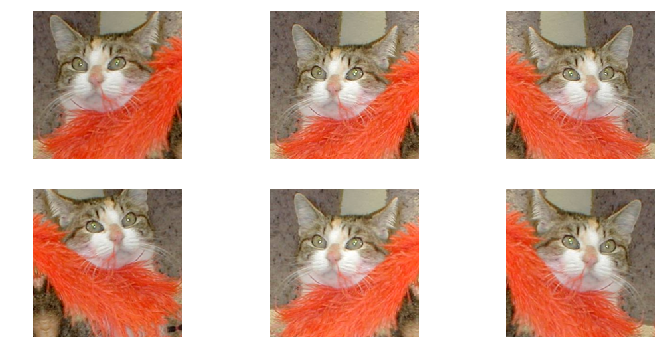

In [38]:
plots(ims, rows=2)

In [39]:
#let us create new data object which will consider augmented data too! 
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
# we will also create a new model object to 
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
#let us train the mode
learn.fit(1e-2,1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.055898   0.029975   0.9915    



[array([0.02997]), 0.9915]

In [41]:
# as we can see there is no major difference in
#terms of error as we are training a model with freezed layers.
#what we will do is unfreeze the last layer which can be done by setting the precompute parameter to false.
learn.precompute=False


In [42]:
"""In a multi dimensional gradient descent problem 
there are lot of flat points/low points where
you can land. Now to choose the best point out of them depends on
each point's periphery. If due to new data the points shifts left/right a little bit and
then loss may increase a lot.

Here 3 is number of cycles. cycle_len denotes after one epoch the learning rate will be reset!
By reset what i mean here is we are going to use
stochastic gradient descent with restart. In sgdr 
we do learning rate cosine based annealing and then jump up the learning rate to original and again to annealing until we 
reach a point which is very safe in terms of its periphery """


learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048808   0.029837   0.9915    
    1      0.046143   0.02848    0.9885                       
    2      0.046883   0.027328   0.9905                       



[array([0.02733]), 0.9905]

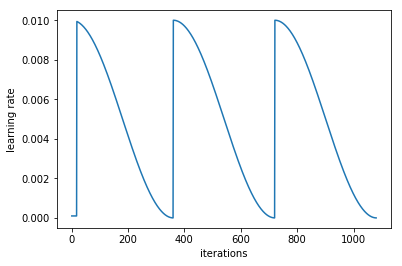

In [43]:
learn.sched.plot_lr()

## FINE-TUNING AND DIFFERENTIAL LEARNING RATE ANNEALING

In [44]:
#let us just unfreeze layers
learn.unfreeze()

In [45]:
#let us just use differential learning rates
lr = np.array([1e-4,1e-3,1e-2])

In [46]:
#here we are setting one more parameter which is cycle_multi which doubles the size of cycle after each cycle
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049114   0.029132   0.988     
    1      0.039822   0.022888   0.991                        
    2      0.034299   0.019999   0.993                        
    3      0.032003   0.023544   0.993                        
    4      0.021437   0.021631   0.9925                       
    5      0.018426   0.021586   0.9925                       
    6      0.016896   0.020946   0.9935                       



[array([0.02095]), 0.9935]

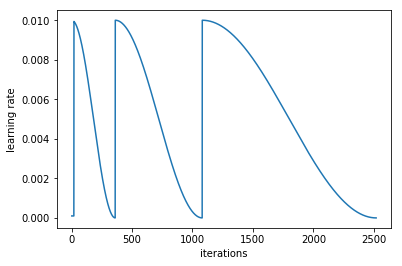

In [47]:
learn.sched.plot_lr()

In [48]:
learn.save('224_all')

In [49]:
learn.load('224_all')

most_incorrect_dogs


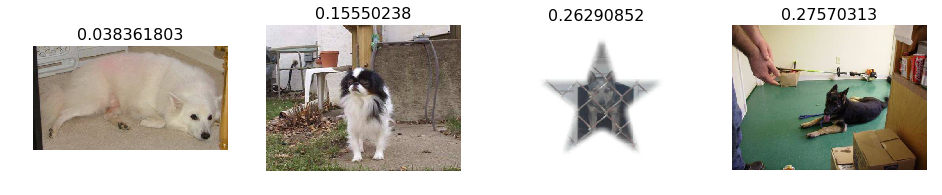

In [50]:
#let us look at results
plot_val_with_title(most_by_correct(1,False),"most_incorrect_dogs")

   ## TEST TIME AUGMENTATION


Here while inferecing / predicting we use four augmented versions of orignal image and then average the predictions!


In [54]:
log_probs,y = learn.TTA()

In [60]:
probs = np.mean(np.exp(log_probs),0)
accuracy_np(probs, y)

0.9935

## CONFUSION MATRIX

In [62]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  8 992]]


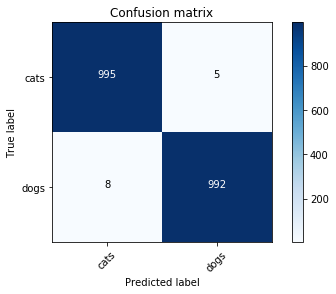

In [64]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


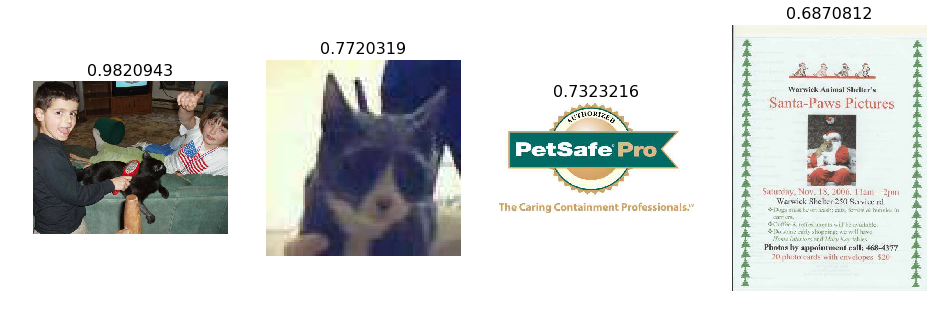

In [65]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


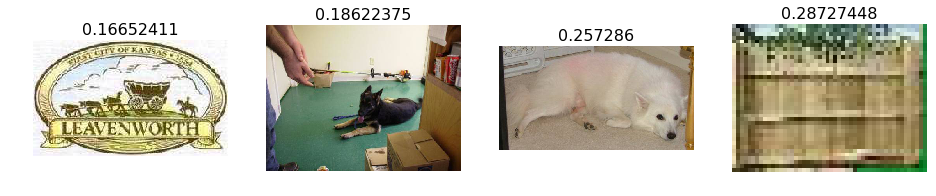

In [66]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")